Mounted at /content/drive
=== 📊 MÉTRICAS DE TU CARTERA (orden solicitado) ===
Capital inicial (€):               591,104
Valor actual (€):                 575,662
Valor regalo (€):                 21,558
Valor actual mejorado (€):        597,219
Retorno total (%):                -2.6%
Retorno total (€):                -15,442
Retorno total mejorado (%):       1.0%
Retorno mejorado (€):             6,115
Drawdown máx.:                    -3.8%
Retorno anualizado (%):           2.2%
Volatilidad anualizada (%):       3.5%

✅ Serie diaria guardada en: /content/drive/MyDrive/investment_ai/reports/portfolio_daily_value.csv


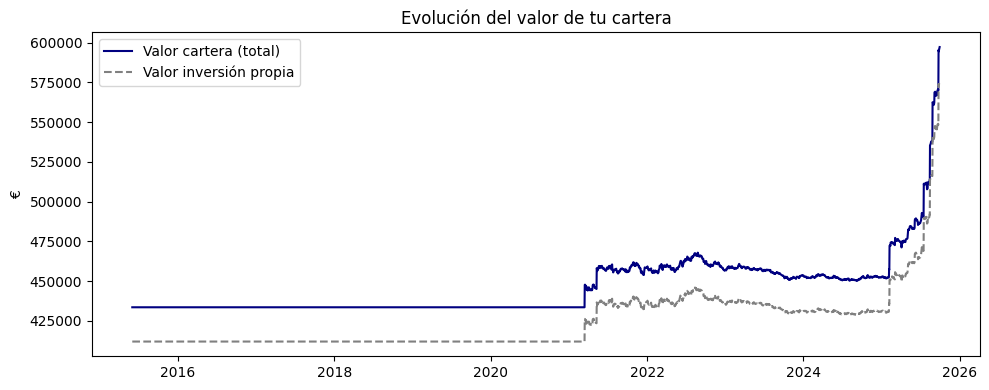

In [1]:
# ============================================
# 06_portfolio_reconstructor.ipynb - Valor diario de TU cartera (FINAL)
# ============================================

!pip -q install yfinance pandas gspread gspread-dataframe

import os
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import auth, drive

drive.mount('/content/drive', force_remount=False)
auth.authenticate_user()

import gspread
from google.auth import default
from gspread_dataframe import get_as_dataframe

creds, _ = default()
gc = gspread.authorize(creds)

BASE = "/content/drive/MyDrive/investment_ai"
DIRS = {
    "data": f"{BASE}/data",
    "clean": f"{BASE}/data/clean",
    "reports": f"{BASE}/reports"
}
for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

# --- 1. Leer historial de compras ---
sh = gc.open("positions_history")
ws = sh.sheet1
positions = get_as_dataframe(ws, evaluate_formulas=True, header=0).dropna(how="all")

# Limpiar
def clean_euro(x):
    if pd.isna(x) or x == "": return 0.0
    s = str(x).replace("€", "").replace(" ", "")
    if re.search(r"\d+\.\d{3},\d{2}$", s):
        s = s.replace(".", "").replace(",", ".")
    else:
        s = s.replace(",", ".")
    try:
        return float(s)
    except:
        return 0.0

import re
positions["Fecha_Compra"] = pd.to_datetime(positions["Fecha_Compra"], dayfirst=True, errors="coerce")
positions["Unidades"] = positions["Unidades"].apply(clean_euro)
positions["ticker_yf"] = positions["ticker_yf"].fillna("CASH").replace("-", "CASH")
positions.loc[positions["nombre"].str.contains("ACN", na=False), "ticker_yf"] = "ACN"

if "tipo_aporte" not in positions.columns:
    positions["tipo_aporte"] = "propio"
else:
    positions["tipo_aporte"] = positions["tipo_aporte"].fillna("propio")

# --- 2. Tickers y precios ---
tickers = [t for t in positions["ticker_yf"].unique() if t != "CASH"]
start_date = positions["Fecha_Compra"].min().strftime("%Y-%m-%d")
prices = yf.download(tickers, start=start_date, end=None, interval="1d", auto_adjust=True, progress=False)

if isinstance(prices.columns, pd.MultiIndex):
    prices = prices["Close"]
else:
    if len(tickers) == 1 and "Close" in prices.columns:
        prices = prices.rename(columns={"Close": tickers[0]})

prices = prices.ffill().bfill()

# --- 3. Reconstruir valor diario ---
non_priced = ["CASH", "0P00000LRT.F", "0P0001FAMF.F", "0P0001K6GO.F", "0P000125YU.L", "IE0007472115.IR"]

value_propio_cotizado = pd.Series(0.0, index=prices.index)
value_regalo_cotizado = pd.Series(0.0, index=prices.index)

for _, row in positions.iterrows():
    ticker = row["ticker_yf"]
    if ticker in non_priced or ticker == "CASH":
        continue
    if ticker not in prices.columns:
        continue

    units = row["Unidades"]
    date = row["Fecha_Compra"]
    tipo = row["tipo_aporte"]
    importe = row["importe_inicial"]

    if tipo == "regalo":
        if units > 0:
            series = prices[ticker].where(prices.index >= date, 0) * units
            value_regalo_cotizado += series
        else:
            value_regalo_cotizado += importe
    else:
        series = prices[ticker].where(prices.index >= date, 0) * units
        value_propio_cotizado += series

# Valor constante de cash y fondos
cash_funds_propio = positions[
    (positions["ticker_yf"].isin(non_priced)) & (positions["tipo_aporte"] == "propio")
]["importe_inicial"].sum()

cash_funds_regalo = positions[
    (positions["ticker_yf"].isin(non_priced)) & (positions["tipo_aporte"] == "regalo")
]["importe_inicial"].sum()

# Valores finales
value_propio = value_propio_cotizado + cash_funds_propio
value_regalo = value_regalo_cotizado + cash_funds_regalo
value_mejorado = value_propio + value_regalo

# Crear DataFrame
portfolio_daily = pd.DataFrame(index=prices.index)
portfolio_daily["valor_propio"] = value_propio
portfolio_daily["valor_regalo"] = value_regalo
portfolio_daily["valor_mejorado"] = value_mejorado

# --- 4. Calcular métricas ---
capital_inicial = positions[positions["tipo_aporte"] == "propio"]["importe_inicial"].sum()
valor_actual = portfolio_daily["valor_propio"].iloc[-1]
valor_regalo_final = portfolio_daily["valor_regalo"].iloc[-1]
valor_mejorado_final = portfolio_daily["valor_mejorado"].iloc[-1]

retorno_total_pct = (valor_actual / capital_inicial) - 1 if capital_inicial > 0 else 0
retorno_total_eur = valor_actual - capital_inicial

retorno_mejorado_pct = (valor_mejorado_final / capital_inicial) - 1 if capital_inicial > 0 else 0
retorno_mejorado_eur = valor_mejorado_final - capital_inicial

portfolio_daily["peak"] = portfolio_daily["valor_mejorado"].cummax()
portfolio_daily["drawdown"] = (portfolio_daily["valor_mejorado"] - portfolio_daily["peak"]) / portfolio_daily["peak"]
drawdown_max = portfolio_daily["drawdown"].min()

first_val = portfolio_daily["valor_mejorado"].iloc[0]
last_val = portfolio_daily["valor_mejorado"].iloc[-1]
days = (portfolio_daily.index[-1] - portfolio_daily.index[0]).days
retorno_anualizado = (last_val / first_val) ** (252 / days) - 1 if days > 0 else 0
volatilidad = portfolio_daily["valor_mejorado"].pct_change().std() * np.sqrt(252)

# --- 5. Mostrar en el orden solicitado ---
print("=== 📊 MÉTRICAS DE TU CARTERA (orden solicitado) ===")
print(f"Capital inicial (€):               {capital_inicial:,.0f}")
print(f"Valor actual (€):                 {valor_actual:,.0f}")
print(f"Valor regalo (€):                 {valor_regalo_final:,.0f}")
print(f"Valor actual mejorado (€):        {valor_mejorado_final:,.0f}")
print(f"Retorno total (%):                {retorno_total_pct:.1%}")
print(f"Retorno total (€):                {retorno_total_eur:,.0f}")
print(f"Retorno total mejorado (%):       {retorno_mejorado_pct:.1%}")
print(f"Retorno mejorado (€):             {retorno_mejorado_eur:,.0f}")
print(f"Drawdown máx.:                    {drawdown_max:.1%}")
print(f"Retorno anualizado (%):           {retorno_anualizado:.1%}")
print(f"Volatilidad anualizada (%):       {volatilidad:.1%}")

# --- 6. Guardar ---
portfolio_daily.to_csv(f"{DIRS['reports']}/portfolio_daily_value.csv", index=True)
print(f"\n✅ Serie diaria guardada en: {DIRS['reports']}/portfolio_daily_value.csv")

# --- 7. Gráfico ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(portfolio_daily.index, portfolio_daily["valor_mejorado"], label="Valor cartera (total)", color="navy")
plt.plot(portfolio_daily.index, portfolio_daily["valor_propio"], label="Valor inversión propia", color="gray", linestyle="--")
plt.title("Evolución del valor de tu cartera")
plt.ylabel("€")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# 06_portfolio_reconstructor.ipynb - Valor diario de TU cartera (MEJORADO + CONTRATO)
# ============================================

import os
import pandas as pd
import numpy as np
import yfinance as yf
import re
import json
from google.colab import auth, drive

# Instalación segura
try:
    import gspread
    from gspread_dataframe import get_as_dataframe
except ImportError:
    !pip -q install yfinance pandas gspread gspread-dataframe
    import gspread
    from gspread_dataframe import get_as_dataframe

drive.mount('/content/drive', force_remount=False)
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

BASE = "/content/drive/MyDrive/investment_ai"
DIRS = {
    "data": f"{BASE}/data",
    "clean": f"{BASE}/data/clean",
    "reports": f"{BASE}/reports"
}
for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

# --- Tickers que no se cotizan (configurable) ---
NON_PRICED_TICKERS = {"CASH", "0P00000LRT.F", "0P0001FAMF.F", "0P0001K6GO.F", "0P000125YU.L", "IE0007472115.IR"}

# --- 1. Leer historial de compras ---
try:
    sh = gc.open("positions_history")
    ws = sh.sheet1
    positions = get_as_dataframe(ws, evaluate_formulas=True, header=0).dropna(how="all")
    print(f"✅ Historial cargado: {positions.shape[0]} posiciones")
except Exception as e:
    raise Exception(f"❌ Error al abrir 'positions_history': {e}")

# --- Validar columnas obligatorias ---
required_cols = ["Fecha_Compra", "Unidades", "ticker_yf", "importe_inicial", "nombre"]
missing_cols = [col for col in required_cols if col not in positions.columns]
if missing_cols:
    raise ValueError(f"❌ Faltan columnas en 'positions_history': {missing_cols}")

# --- Limpiar datos ---
def clean_euro(x):
    if pd.isna(x) or x == "": return 0.0
    s = str(x).replace("€", "").replace(" ", "")
    if re.search(r"\d+\.\d{3},\d{2}$", s):
        s = s.replace(".", "").replace(",", ".")
    else:
        s = s.replace(",", ".")
    try:
        return float(s)
    except:
        return 0.0

positions["Fecha_Compra"] = pd.to_datetime(positions["Fecha_Compra"], dayfirst=True, errors="coerce")
positions["Unidades"] = positions["Unidades"].apply(clean_euro)
positions["importe_inicial"] = positions["importe_inicial"].apply(clean_euro)
positions["ticker_yf"] = positions["ticker_yf"].fillna("CASH").replace("-", "CASH")

# Corregir ticker de ACN
positions.loc[positions["nombre"].str.contains("ACN", na=False), "ticker_yf"] = "ACN"

# Tipo de aporte
if "tipo_aporte" not in positions.columns:
    positions["tipo_aporte"] = "propio"
else:
    positions["tipo_aporte"] = positions["tipo_aporte"].fillna("propio")

# --- 2. Tickers y precios ---
tickers = [t for t in positions["ticker_yf"].unique() if t not in NON_PRICED_TICKERS]
if not tickers:
    raise ValueError("❌ No hay tickers cotizables en el historial.")

start_date = positions["Fecha_Compra"].min()
if pd.isna(start_date):
    raise ValueError("❌ Fecha de compra inválida en el historial.")

start_date = start_date.strftime("%Y-%m-%d")
print(f"📥 Descargando precios desde {start_date} para {len(tickers)} tickers...")

prices = yf.download(tickers, start=start_date, end=None, interval="1d", auto_adjust=True, progress=False)

if isinstance(prices.columns, pd.MultiIndex):
    prices = prices["Close"]
else:
    if len(tickers) == 1 and "Close" in prices.columns:
        prices = prices.rename(columns={"Close": tickers[0]})
    else:
        prices = pd.DataFrame(index=prices.index)

prices = prices.ffill().bfill()
if prices.empty:
    raise ValueError("❌ No se pudieron descargar precios válidos.")

# --- 3. Reconstruir valor diario ---
value_propio_cotizado = pd.Series(0.0, index=prices.index)
value_regalo_cotizado = pd.Series(0.0, index=prices.index)

for _, row in positions.iterrows():
    ticker = row["ticker_yf"]
    if ticker in NON_PRICED_TICKERS:
        continue
    if ticker not in prices.columns:
        print(f"⚠️ Ticker no encontrado en precios: {ticker}")
        continue

    units = row["Unidades"]
    date = row["Fecha_Compra"]
    tipo = row["tipo_aporte"]
    importe = row["importe_inicial"]

    if pd.isna(date):
        print(f"⚠️ Fecha de compra inválida para {ticker}. Saltando.")
        continue

    if tipo == "regalo":
        if units > 0:
            series = prices[ticker].where(prices.index >= date, 0) * units
            value_regalo_cotizado += series
        else:
            # Aporte en efectivo
            value_regalo_cotizado += importe
    else:
        series = prices[ticker].where(prices.index >= date, 0) * units
        value_propio_cotizado += series

# Valor constante de cash y fondos
cash_funds_propio = positions[
    (positions["ticker_yf"].isin(NON_PRICED_TICKERS)) & (positions["tipo_aporte"] == "propio")
]["importe_inicial"].sum()

cash_funds_regalo = positions[
    (positions["ticker_yf"].isin(NON_PRICED_TICKERS)) & (positions["tipo_aporte"] == "regalo")
]["importe_inicial"].sum()

# Valores finales
value_propio = value_propio_cotizado + cash_funds_propio
value_regalo = value_regalo_cotizado + cash_funds_regalo
value_mejorado = value_propio + value_regalo

# Crear DataFrame
portfolio_daily = pd.DataFrame(index=prices.index)
portfolio_daily["valor_propio"] = value_propio
portfolio_daily["valor_regalo"] = value_regalo
portfolio_daily["valor_mejorado"] = value_mejorado

# --- 4. Calcular métricas ---
capital_inicial = positions[positions["tipo_aporte"] == "propio"]["importe_inicial"].sum()
valor_actual = portfolio_daily["valor_propio"].iloc[-1] if not portfolio_daily.empty else 0
valor_regalo_final = portfolio_daily["valor_regalo"].iloc[-1] if not portfolio_daily.empty else 0
valor_mejorado_final = portfolio_daily["valor_mejorado"].iloc[-1] if not portfolio_daily.empty else 0

retorno_total_pct = (valor_actual / capital_inicial) - 1 if capital_inicial > 0 else 0
retorno_total_eur = valor_actual - capital_inicial

retorno_mejorado_pct = (valor_mejorado_final / capital_inicial) - 1 if capital_inicial > 0 else 0
retorno_mejorado_eur = valor_mejorado_final - capital_inicial

portfolio_daily["peak"] = portfolio_daily["valor_mejorado"].cummax()
portfolio_daily["drawdown"] = (portfolio_daily["valor_mejorado"] - portfolio_daily["peak"]) / portfolio_daily["peak"]
drawdown_max = portfolio_daily["drawdown"].min() if not portfolio_daily.empty else 0

if not portfolio_daily.empty:
    first_val = portfolio_daily["valor_mejorado"].iloc[0]
    last_val = portfolio_daily["valor_mejorado"].iloc[-1]
    days = (portfolio_daily.index[-1] - portfolio_daily.index[0]).days
    retorno_anualizado = (last_val / first_val) ** (252 / days) - 1 if days > 0 else 0
    volatilidad = portfolio_daily["valor_mejorado"].pct_change().std() * np.sqrt(252)
else:
    retorno_anualizado = 0
    volatilidad = 0

# --- 5. Mostrar métricas ---
print("=== 📊 MÉTRICAS DE TU CARTERA (orden solicitado) ===")
print(f"Capital inicial (€):               {capital_inicial:,.0f}")
print(f"Valor actual (€):                 {valor_actual:,.0f}")
print(f"Valor regalo (€):                 {valor_regalo_final:,.0f}")
print(f"Valor actual mejorado (€):        {valor_mejorado_final:,.0f}")
print(f"Retorno total (%):                {retorno_total_pct:.1%}")
print(f"Retorno total (€):                {retorno_total_eur:,.0f}")
print(f"Retorno total mejorado (%):       {retorno_mejorado_pct:.1%}")
print(f"Retorno mejorado (€):             {retorno_mejorado_eur:,.0f}")
print(f"Drawdown máx.:                    {drawdown_max:.1%}")
print(f"Retorno anualizado (%):           {retorno_anualizado:.1%}")
print(f"Volatilidad anualizada (%):       {volatilidad:.1%}")

# --- 6. Guardar ---
DAILY_PATH = f"{DIRS['reports']}/portfolio_daily_value.csv"
portfolio_daily.to_csv(DAILY_PATH, index=True)
print(f"\n✅ Serie diaria guardada en: {DAILY_PATH}")

# Guardar métricas para orquestador
metrics_summary = {
    "fecha": pd.Timestamp.now().strftime("%Y-%m-%d"),
    "capital_inicial": float(capital_inicial),
    "valor_actual": float(valor_actual),
    "valor_regalo": float(valor_regalo_final),
    "valor_mejorado": float(valor_mejorado_final),
    "retorno_total_pct": float(retorno_total_pct),
    "retorno_mejorado_pct": float(retorno_mejorado_pct),
    "drawdown_max": float(drawdown_max),
    "retorno_anualizado": float(retorno_anualizado),
    "volatilidad": float(volatilidad)
}

METRICS_PATH = f"{DIRS['reports']}/portfolio_metrics_latest.json"
with open(METRICS_PATH, "w") as f:
    json.dump(metrics_summary, f, indent=2)
print(f"✅ Métricas para orquestador: {METRICS_PATH}")

# --- 7. Gráfico ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
if not portfolio_daily.empty:
    plt.plot(portfolio_daily.index, portfolio_daily["valor_mejorado"], label="Valor cartera (total)", color="navy")
    plt.plot(portfolio_daily.index, portfolio_daily["valor_propio"], label="Valor inversión propia", color="gray", linestyle="--")
plt.title("Evolución del valor de tu cartera")
plt.ylabel("€")
plt.legend()
plt.tight_layout()
GRAPH_PATH = f"{DIRS['reports']}/portfolio_evolution.png"
plt.savefig(GRAPH_PATH, dpi=150)
plt.show()
print(f"✅ Gráfico guardado: {GRAPH_PATH}")

Mounted at /content/drive
